In [1]:
import datetime

import h3 # uber geo package
import pandas as pd
import seaborn as sns
import numpy as np

from tqdm.auto import tqdm

In [2]:
sns.set_theme()
tqdm.pandas()

# load

load reference data for bike station locations

In [ ]:
# TODO update
RAW = "/Users/jbishop/Downloads/cleaned_data_20220612_1302.pickle"

LOCATION_REF = "./data/stations_loc.json"

In [3]:
station_locations_df = pd.read_json(LOCATION_REF).T

main data, load with dask

In [4]:
# load raw data
df = pd.read_pickle(RAW)

In [5]:
# num rows
len(df)

99448614

some cleaning of bad dates

In [6]:
EARLIEST_DATE = datetime.datetime(2010, 1, 1)

In [24]:
%%time
# filter out of range dates
df = df[df["start_date"] > EARLIEST_DATE]
# allow NA for end dates
df = df[(df["end_date"] > EARLIEST_DATE) | df["end_date"].isna()]

# also drop entries where start date before end date
df = df[df["start_date"] < df["end_date"]]

CPU times: user 39 s, sys: 22.6 s, total: 1min 1s
Wall time: 1min 5s


In [25]:
# recalc duration
df["duration"] = df["end_date"]  - df["start_date"] 

# Basic stats

In [26]:
%%time
# how many bikes
df["bike_id"].nunique()

CPU times: user 6.55 s, sys: 920 ms, total: 7.47 s
Wall time: 7.46 s


21149

In [27]:
bike_groups = df.groupby("bike_id")

In [28]:
%%time
# bike with the most trips
group_counts = bike_groups.count()["filename"] # pick abritrary column (without nulls) to get counts
b_id = group_counts.idxmax()
n_trips = group_counts.loc[b_id]

print(f"""
bike with most trips: {b_id}
did {n_trips} trips
""")


bike with most trips: 8875
did 10197 trips

CPU times: user 35.2 s, sys: 559 ms, total: 35.7 s
Wall time: 35.7 s


In [29]:
%%time
# bike with the longest trips
group_sums = bike_groups["duration"].sum()
b_id = group_sums.idxmax()
d_sum = group_sums.loc[b_id]


print(f"""
bike with longest sum duration of trips: {b_id}
total of {d_sum} seconds
""")


bike with longest sum duration of trips: 2143
total of 234 days 19:13:00 seconds

CPU times: user 948 ms, sys: 192 ms, total: 1.14 s
Wall time: 1.14 s


## Long-lived bikes

In [30]:
%%time
trips_per_bike = bike_groups["filename"].count()

CPU times: user 3.53 s, sys: 31.7 ms, total: 3.56 s
Wall time: 3.55 s


In [51]:
%%time
# relies on time ordering of df via rental_id
bike_start = bike_groups["start_date"].first()

CPU times: user 398 ms, sys: 2.44 ms, total: 400 ms
Wall time: 399 ms


In [52]:
%%time
# relies on time ordering of df via rental_id
bike_end = bike_groups["end_date"].last()

CPU times: user 525 ms, sys: 1.4 ms, total: 526 ms
Wall time: 525 ms


In [53]:
%%time 
bike_lifetime = bike_end - bike_start

CPU times: user 1.64 ms, sys: 2.01 ms, total: 3.65 ms
Wall time: 2.7 ms


In [54]:
%%time
duration_sums = bike_groups["duration"].sum()

CPU times: user 1.2 s, sys: 1.57 s, total: 2.77 s
Wall time: 3.55 s


In [55]:
%%time
bike_utilisation = duration_sums / bike_lifetime

CPU times: user 962 µs, sys: 879 µs, total: 1.84 ms
Wall time: 1.59 ms


In [57]:
bike_utilisation.mean()

0.041590354670607635

<AxesSubplot:>

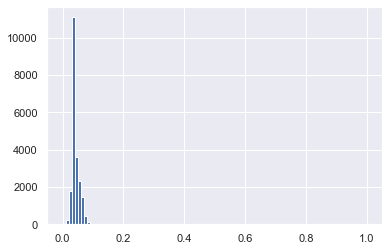

In [58]:
bike_utilisation.hist(bins=100)

### per month

- how many bikes are "alive" by month?

- what is bike utilisation by month?

In [80]:
g.count()

start_date    6390
dtype: int64

In [81]:
starts_per_month = bike_start.to_frame().groupby(pd.Grouper(key="start_date", freq="1M")).count()
starts_per_month = bike_end.to_frame().groupby(pd.Grouper(key="end_date", freq="1M")).count()

In [85]:
for k,g in bike_start.to_frame().groupby(pd.Grouper(key="start_date", freq="1M")):
    break

In [86]:
k

Timestamp('2012-01-31 00:00:00', freq='M')

In [89]:
gs = bike_start.to_frame().groupby(pd.Grouper(key="start_date", freq="1M"))

In [100]:
gs

In [101]:
# WIP currently fighting with group objects

In [65]:
bike_start.groupby(pd.Grouper(freq="1M"))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [62]:
bike_start.groupby([bike_start,pd.TimeGrouper(freq='month')])

AttributeError: module 'pandas' has no attribute 'TimeGrouper'

## Station Areas

In [161]:
%%time
all_stations = pd.concat([
    df[["start_station_id", "start_station_name"]].rename(columns={"start_station_id": "id", "start_station_name": "name"}),
    df[["end_station_id", "end_station_name"]].rename(columns={"end_station_id": "id", "end_station_name": "name"})
]).convert_dtypes().set_index(keys="id").drop_duplicates().dropna()

CPU times: user 478 ms, sys: 51.2 ms, total: 529 ms
Wall time: 528 ms


have a look at station name pieces, is the part after the comma an "area"?

In [162]:
station_name_pieces = all_stations["name"].progress_map(lambda name: name.split(","))

station_single_pieces = station_name_pieces[station_name_pieces.progress_map(len) <= 1]
station_areas =  station_name_pieces.progress_map(lambda name_pieces: name_pieces[1] if len(name_pieces) > 1 else None).dropna()

  0%|          | 0/770 [00:00<?, ?it/s]

  0%|          | 0/770 [00:00<?, ?it/s]

  0%|          | 0/770 [00:00<?, ?it/s]

what are the items with only one "piece" i.e. no comma

In [168]:
station_single_pieces.head()

id
495         [Bow Church Station :Bow]
503    [Cleveland Way :Bethnal Green]
485    [Old Ford Road :Bethnal Green]
780          [Imperial Wharf Station]
446        [York Hall :Bethnal Green]
Name: name, dtype: object

In [164]:
station_areas.value_counts()

 Marylebone        27
 Battersea         19
 Mayfair           18
 Holborn           18
 Kensington        15
                   ..
 Lingham Street     1
Hoxton              1
 Victoria Park      1
Shepherd's Bush     1
 St.John's Wood     1
Name: name, Length: 122, dtype: int64